<a href="https://colab.research.google.com/github/tluxxx/PortfolioExperiments/blob/main/macroeconomic_param_trading_(Lang_type).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trading System following U. Lang
Die besten Aktenstrategien Finanzbuchverlag, Muenchen (2005)

# 1. Preparations

In [ ]:
!pip install ecbdata

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# import data processing libraries
import pandas as pd
import numpy as np
import datetime as dt

# import plotting libraries
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# import data providing libraries
import yfinance as yf
import pandas_datareader as pdr

# 2. General Helper Functions

In [ ]:
# generation of Trading-signals

def calc_sig(pr, start, n):
  ''' calculating positions (LONG and FLAT), based on reaching a high and a low during a period of n_high and n_low periods
      if a high is reached, the position is set to LONG and remains long until a low is reached
      if a low is reached, the position is set to FLAT and remains flat until a high is reached

  Args:
    pr (Series):      series with data to be analysed
    start (date):     start date for any slice of the total data
    n_high (int):     tuple (n_high, n_low) for identifying the max value in a n_high/n_low period
    n_low (int):      period for calculating the min-value

  Returns:
    sig (Series):     series with positions LONG: 1, FLAT: 0,-1

  '''
  n_high, n_low = n[0], n[1]
  val = pr.loc[start:].copy()
  s = np.zeros(len(val))
  h = val.rolling(window=n_high).max()                # rolling max and min
  l = val.rolling(window=n_low).min()
  high = np.where(((val - h) < 0),  0, 1)             # +1 when max is detected
  low = np.where(((val - l) > 0),  0, -1)             # -1 when min is detected
  h_sig = (np.ediff1d(high) == 1).astype(int)         # difference to previous value and filtering for diff = 1 --> LONG-sig
  l_sig = -(np.ediff1d(low) ==-1).astype(int)         # difference to previous value and filtering for diff = -1 --> FLAT-sig
  s = h_sig + l_sig                                   # aggregated signal and adding the one dropped element (caused by diff)
  s = np.insert(s, 0, 0)
  sig = pd.Series(s, index=val.index)                 # genaration position series from signals, preparation and performing of forward filling
  sig.replace(0,np.nan,inplace=True)                  # preparation and performing forward filling of the signals
  sig.ffill(inplace=True)
  sig.fillna(0,inplace=True)
  sig = sig.add(1).div(2).replace(0.5,0)              # norming of the signal (0 = FLAT, 1= LONG)
  return sig

In [ ]:
# Helper function, for calculation of the individual PnL's of elements in a list of strategies
def pnl_strategies(pr, list_strategies):

  for strategy in list_strategies:
    name = 'pnl_' + strategy
    pr[name] = (1 + pr['DAX'].pct_change() * pr[strategy].shift(1)).cumprod()

# Helper function for calculation PnL of combined strategies (democtratic vote)
def pnl_combined_strategies(pr, list_of_strategies, vote_key):

  # generation of name of combined strategy
  name=''
  for strategy in list_of_strategies:
    name = name + strategy +'_'
  name = name[:-1]                # removal last _ to get processable field names

  # calculation of indicator value of combined strtegies (democratic vote), LONG if >= vote_key votes are in favor of LONG, FLAT otherwise
  pr['helper'] = pr[list_of_strategies].sum(axis=1)
  pr[name] = np.where(pr['helper'] >= vote_key, 1, 0)

  # PnL calculation
  name_pnl = 'pnl_' + name
  pr[name_pnl] = (1 + pr['DAX'].pct_change() * pr[name].shift(1)).cumprod()


In [ ]:
# plotting of results

def plotting_pnl(pr, start_pl, end_pl, strategies, mode):
  # preparations
  temp = params.loc[start_pl:end_pl].copy()

  main_title = 'development of PnL of strategies vs. B&H'
  sub_title = f'instrument: {ticker}, analyzed  from: {start_pl} to:{end_pl}'
  title = main_title + '<br><br><sup>' + sub_title + '</sup>'

  # plotting of results
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=temp.index, y=temp['pnl_buh'] / temp.iloc[0]['pnl_buh'], line_color = 'red', line_width = 6, name='PnL buh'))

  for strategy in strategies:
    name ='pnl_' + strategy
    fig.add_trace(go.Scatter(x=temp.index, y=temp[name]/temp.iloc[0][name], name=f' PnL - {strategy}'))

  if mode == 'log':
    fig.update_layout(yaxis_type="log")

  fig.update_layout(legend_title ='Strategies', template='plotly_dark', autosize=False, width=1500, height=800)
  fig.update_layout(title=title, xaxis_title='date', yaxis_title='PnL')
  fig.show()

In [ ]:
# plotting results

def plot_overperf_end_dates(res, start_dt, strategies):
  # preparations
  main_title = 'over parformance of Strategies over Buy & Hold for different end_dates'
  sub_title = f'instrument: {ticker}, analyzed  from: {start_dt} to: various end_dates'
  title = main_title + '<br><br><sup>' + sub_title + '</sup>'

  fig = go.Figure()
  for strat in strategies:
    name='over_perf_' + strat
    fig.add_trace(go.Scatter(x=res.index, y=res[name], mode='lines+markers', name=f'over-performance-{strat}'))
  fig.update_layout(legend_title ='Sources', template='plotly_dark', autosize=False, width=1500, height=800)
  fig.update_layout(title=title, xaxis_title='end-date', yaxis_title='over-performance')
  fig.show()

def plot_overperf_start_dates(res, end_dt, strategies):
  # preparations
  main_title = 'overperformance of Strategies over Buy & Hold for different start_dtes'
  sub_title = f'instrument: {ticker}, analyzed  from: various start dates to: {end_dt}'
  title = main_title + '<br><br><sup>' + sub_title + '</sup>'

  fig = go.Figure()
  for strat in strategies:
    name='over_perf_' + strat
    fig.add_trace(go.Scatter(x=res.index, y=res[name], mode='lines+markers', name=f'over-performance-{strat}'))
  fig.update_layout(legend_title ='Sources', template='plotly_dark', autosize=False, width=1500, height=800)
  fig.update_layout(title=title, xaxis_title='start-date', yaxis_title='over-performance')
  fig.show()


# 3. downloading data and initialisation & filling results-data-frame

In [ ]:
# importing the DAX-data
start_period, end_period = '1988-01-01', '2024-07-31'   # download data for analyses
ticker ='^GDAXI'
dax_d = yf.download(ticker, start=start_period, end=end_period)
dax_d['date'] = dax_d.index

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# preparing the data frame for the results (trading)

## finding trading day (each first trading day of a week) and analyses days (last trading day of the previous week)
trade_dts = dax_d.resample('W').first()['date'].tolist()
analyses_dts = dax_d.resample('W').last()['date'].tolist()

## initalizing the results dataframe
params = pd.DataFrame({'trade_dates': trade_dts,
                       'analyses_dates': analyses_dts})
params['analyses_dates'] = params['analyses_dates'].shift(1)

## populating with the DAX-Open-values at the trading day-dates, dropping the first row
dax_temp = dax_d[['date','Open']].copy()
dax_temp.rename(columns={'date':'trade_dates','Open':'DAX'}, inplace=True)
params = pd.merge(params, dax_temp, on='trade_dates', how='left')
params = params.iloc[1:]

## generation of list of dates of all trading-days and analyses-days
trade_dates = params['trade_dates'].tolist()
analyses_dates = params['analyses_dates'].tolist()


In [ ]:
# loading interest data US and GER and merging to results -dataframe

## loading and processing 10 years treasury bill from FRED
temp_int1 = pdr.get_data_fred('DGS10', start_period, end_period) # Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis
temp_int1.ffill(inplace=True)
tnotes_10y = pd.DataFrame({'int_US':temp_int1.DGS10.tolist(),
                           'analyses_dates':temp_int1.index.to_list()},
                          index=temp_int1.index.tolist())

## loading and processing "Umlaufrendite" Germany from downloaded data from German Bundesbank
umlauf_rdt = pd.read_excel('/content/gdrive/My Drive/ColabNotebooks/VariousTopics/PortfolioTests/data/UmlaufrenditeGermany_daily_(1978-2024).xlsx', sheet_name='DATA')
umlauf_rdt.replace('.', np.nan, inplace=True)
umlauf_rdt.interest.astype(float)
umlauf_rdt.date = pd.to_datetime(umlauf_rdt.date)
umlauf_rdt.rename(columns={'date':'analyses_dates', 'interest':'int_GER'}, inplace=True)

## merging to the results dataframe via data
params = pd.merge(params, tnotes_10y, on = 'analyses_dates', how='left')
params = pd.merge(params, umlauf_rdt, on = 'analyses_dates', how='left')


In [ ]:
# oil prices
## get brent_price data from FRED
temp = pdr.get_data_fred('DCOILBRENTEU', start=start_period, end=end_period)
brent = pd.DataFrame({'brent':temp.DCOILBRENTEU.tolist(),
                      'analyses_dates':temp.index.to_list()})

## merge to the results dataframe
params = pd.merge(params, brent, on = 'analyses_dates', how='left')

In [ ]:
# Download exchange rates EUR-USD from different sources, aggregating to one time-series and merging to results dataframe

## preparation
switch_date_curr = '1999-01-01'                     # switch from German Bundesbank to ECB data

## uploading USD-DM historical exchange rates (previously downloaded from German Bundesbank)
data_db = pd.read_excel('/content/gdrive/My Drive/ColabNotebooks/VariousTopics/PortfolioTests/data/ExchangeRates_(USD_DM)_(until 1998).xlsx', sheet_name='DATA')
data_db[data_db['data'] =='.'] = np.nan
data_db.rename(columns = {'data':'rate'}, inplace = True)
data_db.rate.astype(float)
data_db.dropna(inplace=True)

## conversion of USD-DM data to EUR-USD
eur_usd_db = data_db
eur_usd_db.rate = 1 / eur_usd_db.rate.div(1.95583)           # reverting the currency pair and transforming to EURO

## importing the relevant EURO-USD historical exchange rates from FRED (daily data for each US bank day) (series starts at switch_date_curr)
eur_usd_fred = pdr.data.DataReader('DEXUSEU', 'fred', switch_date_curr, end_period)
eur_usd_fred.reset_index(inplace=True)
eur_usd_fred.rename(columns = {'DEXUSEU':'rate', 'DATE':'date'}, inplace = True)

## merger of the two sets to an aggregatet EUR-USD-time-series
eur_usd = pd.concat([eur_usd_db,eur_usd_fred])
eur_usd.rename(columns={'date':'analyses_dates', 'rate':'EUR_USD'}, inplace=True)

# merger into the results data frame
params = pd.merge(params, eur_usd, on = 'analyses_dates', how='left')

In [ ]:
# download and process NASDAQ-Composite and DJ-Utilites, integration into results dataframe

## download NASDAQ-composite from FRED
temp = pdr.get_data_fred('NASDAQCOM', start=start_period, end=end_period)
nasdaq_c = pd.DataFrame({'NASDAQ_C':temp.NASDAQCOM.tolist(),
                         'analyses_dates':temp.index.tolist()})

## merge to the results dataframe
params = pd.merge(params, nasdaq_c, on = 'analyses_dates', how='left')


## DOW JONES Ulitiy Average, collection of data from WSJ (until 2014-08-08) and FRED (since 2014-08-07)
dju_w = pd.DataFrame()
cut_off_date = '2014-8-06'

## downloading data from Wall Street Journal and pre-processing
dju_csv = pd.read_csv('/content/gdrive/My Drive/ColabNotebooks/VariousTopics/PortfolioTests/data/DJ_UtilityAverage(1988-2024).csv')
dju_w['date'] = pd.to_datetime(dju_csv['Date'])
dju_w['DJU'] = dju_csv[dju_csv.columns[4]]
dju_w.sort_values(by=['date'], ascending=True, inplace=True)
dju_wsj = dju_w.loc[dju_w.date < cut_off_date].copy()
dju_wsj.rename(columns={'date':'analyses_dates'}, inplace=True)

## downloading data from FRED
temp = pdr.get_data_fred('DJUA', start=start_period, end=end_period)
dju_fred = pd.DataFrame({'DJU':temp.DJUA.tolist(),
                         'analyses_dates':temp.index.tolist()})

## combining the data from WSJ and FRED
dju = pd.concat([dju_wsj, dju_fred])

## merge to the results dataframe
params = pd.merge(params, dju, on = 'analyses_dates', how='left')


<ipython-input-44-1e86bff65a08>:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dju_w['date'] = pd.to_datetime(dju_csv['Date'])


# 4. Calculation of PnL of Lang sub-strategies and combination strategies

In [ ]:
# identification missing values
columns = params.columns.tolist()
for column in columns:
  print(f'nb of NaN in column {column}:   {params[column].isna().sum()}')
print(f'total number of NaN:              {params.isna().sum().sum()}')

# completion option
#params.interpolate(method='linear', axis=0, inplace=True)
params.ffill(inplace=True)  # brute force, pruefen warum einzelne elemente um den 06. und 07. Juli immer wieder auffaelleig sind.

for column in columns:
  print(f'nb of NaN in column {column}:   {params[column].isna().sum()}')
print(f'total number of NaN:              {params.isna().sum().sum()}')

# final rearrangement of results dataframe
params.set_index('trade_dates', inplace=True)


nb of NaN in column trade_dates:   0
nb of NaN in column analyses_dates:   0
nb of NaN in column DAX:   0
nb of NaN in column int_US:   0
nb of NaN in column int_GER:   0
nb of NaN in column brent:   9
nb of NaN in column EUR_USD:   13
nb of NaN in column NASDAQ_C:   11
nb of NaN in column DJU:   14
total number of NaN:              47
nb of NaN in column trade_dates:   0
nb of NaN in column analyses_dates:   0
nb of NaN in column DAX:   0
nb of NaN in column int_US:   0
nb of NaN in column int_GER:   0
nb of NaN in column brent:   0
nb of NaN in column EUR_USD:   0
nb of NaN in column NASDAQ_C:   0
nb of NaN in column DJU:   0
total number of NaN:              0


In [ ]:
# Calculation of position of Lang-sub-strategies

## Interest sub-strategy
n_interest = (38, 38)              # look back period in wks (n_high, n_low)
int1 = calc_sig(params['int_US'], start_period, n_interest)
int2 = calc_sig(params['int_GER'], start_period, n_interest)
int0 = ((int1 + int2).replace(1.5,0).replace(1,0) / 2)
params['interest'] = 1 - int0      # LONG (=1): interest decline, FLAT (=0): interest incerease

## oil price sub-strategy
n_oil = (6, 6)                     # look back period in wks (n_high, n_low)
oil = calc_sig(params['brent'], start_period, n_oil)
params['oil'] = 1 - oil            # LONG (=1): oil decreases, FLAT (=0): oil price incereases
params['oil_inv'] = oil            # LONG (=1): oil price incereases, FLAT (=0): oil price decreases

## currency exchange rate sub-strategy
n_cur = (15, 15)                   # look back period in wks (n_high, n_low)
cur = calc_sig(params['EUR_USD'], start_period, n_cur)
params['cur'] = 1 - cur            # LONG (=1): EUR-USD decreases (stronger USD), FLAT (=0): EUR-USD increases (weaker USD)

## seasonality saisonality sub-strategy (LONG (=1): during Nov, Dec, Jan, Feb, March, April, FLAT (=0): otherwise)
params['season'] = np.where(params.index.month.isin([11,12,1,2,3,4]), 1, 0)

# US stock market sub-strategy
n_usst =(10, 10)                   # look back period in wks (n_high, n_low)
ust1 = calc_sig(params['NASDAQ_C'], start_period, n_usst)
ust2 = calc_sig(params['DJU'], start_period, n_usst)
ust0 = ((ust1 + ust2).replace(1.5,0).replace(1,0) / 2)
params['usst'] = ust0              # LONG (=1): US-stocks increases, FLAT (=0): US-stocks decreases

#finetuning:
col_list = ['interest','oil','oil_inv', 'cur','usst']
params[col_list] = params[col_list].astype(int)


In [ ]:
# compilation of results

# definition of strategy-sets
base_strategies = ['interest', 'oil', 'oil_inv', 'cur', 'season', 'usst']
combined_strategies = ['oil_season_cur', 'oil_inv_season_cur', 'oil_season_cur_usst_interest', 'oil_inv_season_cur_usst_interest']

# calculation PnL of Buy & Hold as reference
params['pnl_buh'] = (1 + params['DAX'].pct_change()).cumprod()

# calculation of PnL of the base strategies
pnl_strategies(params, base_strategies)

# combined_strategy 1 - oil & season & currency
combi1 = ['oil', 'season', 'cur']
vote_key = 2
pnl_combined_strategies(params, combi1, vote_key)

# combined_strategy 2 - oil & season & currency
combi2 = ['oil_inv', 'season', 'cur']
vote_key = 2
pnl_combined_strategies(params, combi2, vote_key)

# combined_strategy 3 - (oil & season & currency) & usstocks & interest
combi3= ['oil_season_cur', 'usst', 'interest']
vote_key = 2
pnl_combined_strategies(params, combi3, vote_key)

# combined_strategy 4 - (oil_inverted & season & currency) & usstocks & interest
combi4 = ['oil_inv_season_cur', 'usst', 'interest']
vote_key = 2
pnl_combined_strategies(params, combi4, vote_key)

In [ ]:
# plotting PnL of sub-strategies (baselines)
start_plot, end_plot = '1988-01-15', '2024-05-31'
mode = 'nonlog' #'log'
plotting_pnl(params, start_plot, end_plot, base_strategies, mode)

In [ ]:
#  plotting PnL of combined_strategies
mode = 'nonlog'   # 'log'
plotting_pnl(params, start_plot, end_plot, combined_strategies, mode)

In [ ]:
# plotting indicators of base-line-strategies

fig = make_subplots(rows=6, cols=1, subplot_titles=base_strategies)

for i, strategy in enumerate(base_strategies):
  fig.add_trace(go.Scatter(x=params.index, y = params[strategy], name=strategy), row=i+1, col=1)
fig.update_layout(legend_title ='Strategies', template='plotly_dark', autosize=False, width=1500, height=800)

fig.show()

In [ ]:
# Overperformance, depending on varied start and end_dates

# preparation
start_dates = pd.date_range('1989-01-01', '2019-12-31', freq='YS')
end_dates = pd.date_range('1989-01-01', '2019-12-31', freq='YS')
res_x_start, res_x_end = [], []
all_strategies = base_strategies + combined_strategies

# looping through all end_dates
for end_date in end_dates:
  params_calc = params.loc[:end_date].copy()
  res = []
  temp1 = params_calc['pnl_buh'][-1] / params_calc['pnl_buh'][1]  # ACHTUNG: nan in row 809 --> korrigieren

  for strategy in all_strategies:
    name = 'pnl_' + strategy
    temp2 = params_calc[name][-1] / params_calc[name][1]
    res.append(temp2 / temp1)
  res_x_end.append(res)

# looping through all start_dates
for start_date in start_dates:
  params_calc = params.loc[start_date:].copy()
  res = []
  temp1 = params_calc['pnl_buh'][-1] / params_calc['pnl_buh'][1]  # ACHTUNG: nan in row 809 --> korrigieren

  for strategy in all_strategies:
    name = 'pnl_' + strategy
    temp2 = params_calc[name][-1] / params_calc[name][1]
    res.append(temp2 / temp1)
  res_x_start.append(res)

# compilation of final resuls
name_all_strategies = ['over_perf_' + strategy for strategy in all_strategies]
res_varied_end = pd.DataFrame(res_x_end, columns=name_all_strategies, index=end_dates)
res_varied_start = pd.DataFrame(res_x_start, columns=name_all_strategies, index=start_dates)

<ipython-input-99-aef80c77cb01>:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-99-aef80c77cb01>:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-99-aef80c77cb01>:25: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-99-aef80c77cb01>:29: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consisten

In [ ]:
# final PnL of base strategies, depending on the end_datestart_period
plot_overperf_end_dates(res_varied_end,start_period, all_strategies)   # pruefen, eigentlich muessten alle bei 1 starten, oder???

In [ ]:
# final PnL of base strategies, depending on the end_date
plot_overperf_start_dates(res_varied_start, end_period, all_strategies)

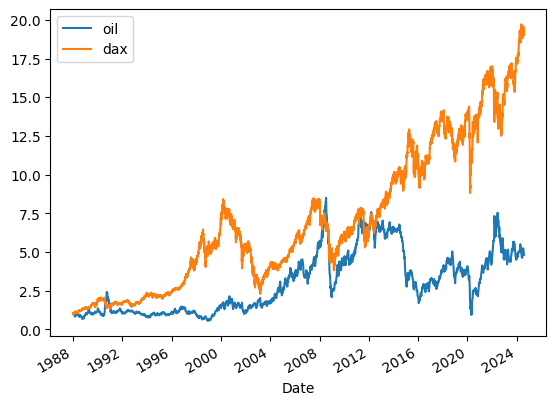

In [ ]:
# Correlation oil and dax
oil_norm = params['brent'] / params['brent'].iloc[0]
dax_norm = dax_d.Close / dax_d.iloc[0]['Close']

oil_norm.plot()
dax_norm.plot()
plt.legend(['oil', 'dax'])
plt.show()

In [ ]:
# checking for
oil_d = pdr.get_data_fred('DCOILBRENTEU', start=start_period, end=end_period)

cor_test = dax_d
cor_test = cor_test.join(oil_d)
cor_test = cor_test.dropna()
z1 = np.corrcoef(cor_test.Close, cor_test.DCOILBRENTEU)
print(z1)
cor_test['dax_norm'] = cor_test.Close / cor_test.Close.iloc[0]
cor_test['oil_norm'] = cor_test.DCOILBRENTEU / cor_test.DCOILBRENTEU.iloc[0]
z2 = np.corrcoef(cor_test.dax_norm, cor_test.oil_norm)
print(z2)
cor_test['dax_norm_diff'] = cor_test.dax_norm.diff()
cor_test['oil_norm_diff'] = cor_test.oil_norm.diff()
cor_test = cor_test.dropna()
z3 = np.corrcoef(cor_test.dax_norm_diff, cor_test.oil_norm_diff)
z4 = cor_test.dax_norm_diff.corr(cor_test.oil_norm_diff)
print(z3)
print(z4)


[[1.         0.60055669]
 [0.60055669 1.        ]]
[[1.         0.60055669]
 [0.60055669 1.        ]]
[[1.         0.16524176]
 [0.16524176 1.        ]]
0.1652417631098164


In [ ]:
correlation = cor_test.dax_norm_diff.corr(cor_test.oil_norm_diff)
print(correlation)

0.1652417631098164


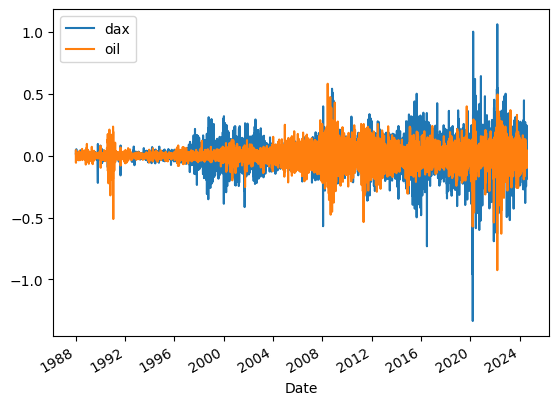

In [ ]:
cor_test.dax_norm_diff.plot()
cor_test.oil_norm_diff.plot()
plt.legend(['dax', 'oil'])
plt.show()